# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from darwinian_shift import DarwinianShift, GlobalKmerSpectrum, TranscriptKmerSpectrum, EvenMutationalSpectrum
from darwinian_shift import CDFPermutationTest, ChiSquareTest, PermutationTest
from darwinian_shift import FoldXLookup, SequenceDistanceLookup, MutationExclusionLookup, StructureDistanceLookup
from darwinian_shift import MutationExclusionLookup, ORLookup
from darwinian_shift import hide_top_and_right_axes

In [3]:
from darwinian_shift.additional_plotting_functions import plot_scatter_two_scores

In [4]:
from darwinian_shift.utils.sifts_functions import get_sifts_alignment
import os

# Setup

In [5]:
# Load data
data = pd.read_excel("aau3879_TableS2.xlsx", skiprows=17, sheet_name='Mutations_collapsed_by_distance')

In [6]:
# Define the region to test
section_definition_egf11_12 = {
    'transcript_id': 'ENST00000277541', 'pdb_id': '2vj3', 'pdb_chain': 'A', 
    'start': 412, 'end': 488 # Restrict to the residues in EGF11-12
}

In [7]:
# Define the mutational spectra
main_fig_spectrum=GlobalKmerSpectrum(
        k=3,  # Use a trinucleotide context,
        ignore_strand=False,  # Transcribed strand of the protein matters, so have 192 different mutation types
        deduplicate_spectrum=False,  # Do not remove duplicate mutations when calculating the spectrum
        name=''  # Use a blank name, so in the plots it will just say "Expected"
    )

supp_fig_spectra = [EvenMutationalSpectrum()]
for glob in [1, 0]: # Global or per transcript spectrum
    for k in [1, 3, 5]:  # Nucleotide context. No wider context, trinucleotide and pentanucleotide
        for ignore_strand in [1, 0]:  # Combine transcribed/non-transcribed strand or not
            for deduplicate_spectrum in [0, 1]:  # Don't/do remove duplicate mutations as these may be positively selected
                num_rates = 6*4**(k-1)
                if not ignore_strand:
                    num_rates *= 2
                if deduplicate_spectrum:
                    dedup = '_dedup'
                else:
                    dedup = ''
                
                if glob:
                    # Add a global spectrum (all genes assumed to have the same spectrum)
                    supp_fig_spectra.append(GlobalKmerSpectrum(
                        k=k, ignore_strand=ignore_strand, deduplicate_spectrum=deduplicate_spectrum, 
                        # Spectra need unique names for creation of dataframe columns
                        name='global_{}{}'.format(num_rates, dedup) 
                    ))
                else:
                    # Add transcript spectrum (all transcripts assumed to have their own unique spectrum)
                    supp_fig_spectra.append(TranscriptKmerSpectrum(
                        k=k, ignore_strand=ignore_strand, deduplicate_spectrum=deduplicate_spectrum, 
                        # Spectra need unique names for creation of dataframe columns
                        name='transcript_{}{}'.format(num_rates, dedup)
                    ))

spectra = [main_fig_spectrum] + supp_fig_spectra

In [8]:
# Define the statistical tests

cdf_perm = CDFPermutationTest(num_permutations=100000, testing_random_seed=0)  # Used to calculate main text p-values

# Define alternative permutation tests using mean and median instead of cdf scores.
mean_perm = PermutationTest(num_permutations=100000, stat_function=np.mean, name='perm_mean', testing_random_seed=0)
median_perm = PermutationTest(num_permutations=100000, stat_function=np.median, name='perm_median', 
                              testing_random_seed=0)

chi_sq = ChiSquareTest(bins=[-0.1, 0.5, 1.1])  # Used to calculate counts for the discrete metrics

stats = [cdf_perm, mean_perm, median_perm, chi_sq]

In [9]:
# Make a DarwinianShift object for the project. 
# This calculates the mutational spectrum, sets up the statistical tests to use, and filters the data. 
d = DarwinianShift(
    data=data, 
    source_genome='GRCh37',
    spectra=spectra,
    stats=stats,
    
    # Just test with the missense mutations. Nonsense and synonymous mutations are still used to calculate the spectrum
    included_mutation_types='missense'
)

In [10]:
plot_directory="./NOTCH1_EGF11_12_figures/"
if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)
    
sifts_directory="."
pdb_directory = "."

In [11]:
# Colours

unobserved_colour = '#BBBBBB'  
observed_colour = '#EE7733'

foldx_expected_colour = '#EE6677'
foldx_observed_colour = '#CC3311'

interface_expected_colour = '#88CCEE'
interface_observed_colour = '#0077BB'

calcium_expected_colour = '#8DE0D7'
calcium_observed_colour = '#009988'

# FoldX

In [12]:
# Define the FoldX lookup
fold = FoldXLookup(foldx_results_directory="./FoldX_results/",
                      sifts_directory=sifts_directory,
                      foldx_file_name_start="PS_f*", download_sifts=True)

In [13]:
d_fold = d.change_lookup(fold)

In [14]:
s_fold = d_fold.run_section(section_definition_egf11_12, spectra=main_fig_spectrum, 
                           statistics=[cdf_perm, mean_perm, median_perm])

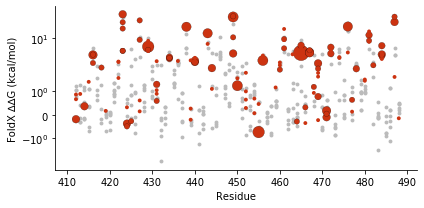

In [15]:
s_fold.plot_scatter(figsize=(6, 3), plot_scale='symlog', show_legend=False, 
                    unobserved_mutation_colour=unobserved_colour, 
                    missense_mutation_colour=foldx_observed_colour, 
                    unmutated_marker_size=15, base_marker_size=15,
                   )
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'scatter_foldx_efg11_12.pdf'), transparent=True)

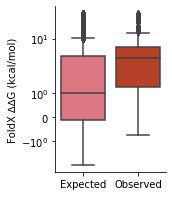

In [16]:
s_fold.plot_boxplot(figsize=(2.5, 3), plot_scale='symlog', spectra=main_fig_spectrum, 
                    colours=[foldx_observed_colour, foldx_expected_colour])
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'boxplot_foldx_efg11_12.pdf'), transparent=True)

In [17]:
s_fold_results = s_fold.get_results_dictionary()

In [18]:
s_fold_results['num_mutations']

308

In [19]:
s_fold_results['CDF_perm__pvalue']  # P-value of the permutation test

1.999980000199998e-05

In [20]:
# P-values using the alternative permutation tests. 
s_fold_results['perm_mean__pvalue'], s_fold_results['perm_median__pvalue']

(1.999980000199998e-05, 1.999980000199998e-05)

# Interface residues

## Defining the interface

In [21]:
# Using the interface residues defined in Luca et al 2017
# Add these residues to the section definition
section_definition_egf11_12['interface_residues'] = [413, 415, 418, 420, 421, 422, 423, 424, 425, 
                                                     435, 436, 444, 447, 448, 450, 451, 452, 454, 
                                                     466, 467, 468, 469, 470, 471, 475, 477, 478, 
                                                     479, 480]

## Testing on full set of mutations

In [22]:
# Define a lookup object which determines whether mutations are on the NOTCH1-ligand interface. 
interface_lookup = SequenceDistanceLookup(
    boolean=True,   # Just a boolean on/off interface. 
    target_key='interface_residues',   # Use this entry in the section_definition dict to define the target residues
    position_type='residue',   # Use the residue number (as opposed to cdspos or chromosomal position)
    name='On interface'  # Label to appear on plot axes
)

In [23]:
d_interface1 = d.change_lookup(interface_lookup)

In [24]:
s_interface1 = d_interface1.run_section(section_definition_egf11_12, spectra=main_fig_spectrum)

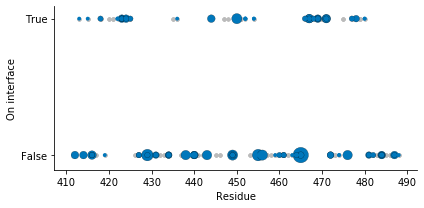

In [25]:
s_interface1.plot_scatter(figsize=(6, 3), show_legend=False, 
                          unobserved_mutation_colour=unobserved_colour, 
                          missense_mutation_colour=interface_observed_colour, 
                         base_marker_size=15, unmutated_marker_size=15)
plt.yticks([0, 1], ['False', 'True']);
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'scatter_interface1_efg11_12.pdf'), transparent=True)

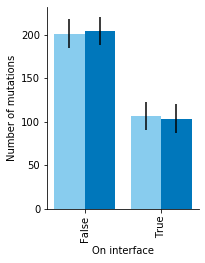

In [26]:
s_interface1.plot_binned_counts(figsize=(3, 4), show_legend=False, spectra=main_fig_spectrum,
                                     colours=[interface_observed_colour, interface_expected_colour])
hide_top_and_right_axes()
plt.title('')
plt.xticks(plt.gca().get_xticks(), ['False', 'True'])
plt.xlabel('On interface')
plt.subplots_adjust(left=0.3, bottom=0.3, right=1, top=1)
plt.savefig(os.path.join(plot_directory, 'bar_interface1_efg11_12.pdf'), transparent=True)

In [27]:
s_interface1_results = s_interface1.get_results_dictionary()

In [28]:
s_interface1_results['num_mutations']

308

In [29]:
# Use the chi-square test to get the proportions expected and observed on the interface.
s_interface1_results['chi_square__binom_expected'], s_interface1_results['chi_square__binom_observed']

(0.3455963868708081, 0.3344155844155844)

In [30]:
s_interface1_results['CDF_perm__pvalue']  # P-value of the permutation test

0.7323926760732392

In [31]:
# P-values using the alternative permutation tests. 
s_interface1_results['perm_mean__pvalue'], s_interface1_results['perm_median__pvalue']

(0.7261527384726153, 1)

## Testing after excluding destabilising mutations

We can use the FoldX lookup to exclude mutations that are highly destabilising.  
We are then testing if, *out of the non-destabilising mutations*, there is a statistically significant enrichment of the mutations on the ligand binding interface.   

We exclude the destabilising mutations from both the null hypothesis and the observed mutations so that the results are not skewed.  

In [32]:
# Define the combined lookup.
excllook = MutationExclusionLookup(
    lookup=interface_lookup,   # Use the interface lookup for the test
    exclusion_lookup=fold,   # Use the foldX lookup to exlcude mutations that have large ∆∆G values 
    exclusion_threshold=2,  # Pick a threshold of 2kcal/mol 
    exclusion_direction=1,   # Exclude mutations with a ∆∆G score larger than the threshold.
    name='On interface'
)

In [33]:
d_interface2 = d.change_lookup(excllook)

In [34]:
s_interface2 = d_interface2.run_section(section_definition_egf11_12, spectra=main_fig_spectrum)

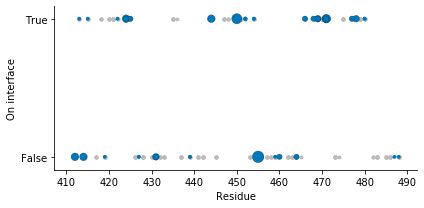

In [35]:
s_interface2.plot_scatter(figsize=(6, 3), show_legend=False, 
                         unobserved_mutation_colour=unobserved_colour, 
                          missense_mutation_colour=interface_observed_colour,
                         base_marker_size=15, unmutated_marker_size=15)
plt.yticks([0, 1], ['False', 'True']);
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'scatter_interface2_efg11_12.pdf'), transparent=True)

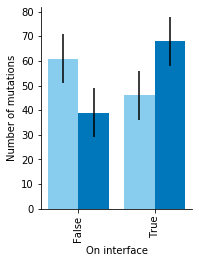

In [36]:
s_interface2.plot_binned_counts(figsize=(3, 4), show_legend=False, spectra=main_fig_spectrum, 
                                     colours=[interface_observed_colour, interface_expected_colour])
plt.title('')
hide_top_and_right_axes()
plt.xticks(plt.gca().get_xticks(), ['False', 'True'])
plt.xlabel('On interface')
plt.subplots_adjust(left=0.3, bottom=0.3, right=1, top=1)
plt.savefig(os.path.join(plot_directory, 'bar_interface2_efg11_12.pdf'), transparent=True)

In [37]:
s_interface2_results = s_interface2.get_results_dictionary()

In [38]:
s_interface2_results['num_mutations']

107

In [39]:
s_interface2_results['chi_square__binom_expected'], s_interface2_results['chi_square__binom_observed']

(0.4317494095414048, 0.6355140186915887)

In [40]:
s_interface2_results['CDF_perm__pvalue']  # P-value of the permutation test

3.999960000399996e-05

In [41]:
# P-values using the alternative permutation tests. 
s_interface2_results['perm_mean__pvalue'], s_interface2_results['perm_median__pvalue']

(3.999960000399996e-05, 0.15543844561554385)

### Altering the ∆∆G threshold

In [42]:
thresholds = [1, 1.5, 2, 2.5, 3]  # Try different thresholds for excluding destabilising mtuations
excllookups = [
MutationExclusionLookup(
    lookup=interface_lookup,   # Use the interface lookup for the test
    exclusion_lookup=fold,   # Use the foldX lookup to exlcude mutations that have large ∆∆G values 
    exclusion_threshold=t,  # Use the given threshold
    exclusion_direction=1,   # Exclude mutations with a ∆∆G score larger than the threshold.
    name='On interface'
) for t in thresholds]

d_interface_with_thresholds = [d.change_lookup(i) for i in excllookups]
s_interfaces_with_thresholds = [
    dd.run_section(section_definition_egf11_12, spectra=main_fig_spectrum) for dd in d_interface_with_thresholds
]
results = [s.get_results_dictionary() for s in s_interfaces_with_thresholds]

In [43]:
observed_counts = np.concatenate([r['chi_square__observed_counts'] for r in results])
expected_counts = np.concatenate([r['chi_square__expected_counts'] for r in results])
observed_ci_low = np.concatenate([r['chi_square__observed_CI_low'] for r in results])
observed_ci_high = np.concatenate([r['chi_square__observed_CI_high'] for r in results])
expected_ci_low = np.concatenate([r['chi_square__expected_CI_low'] for r in results])
expected_ci_high = np.concatenate([r['chi_square__expected_CI_high'] for r in results])
pvalues = [r['CDF_perm__pvalue'] for r in results]

In [44]:
pvalues

[0.0007399926000739993,
 0.00021999780002199978,
 3.999960000399996e-05,
 5.999940000599994e-05,
 0.01091989080109199]

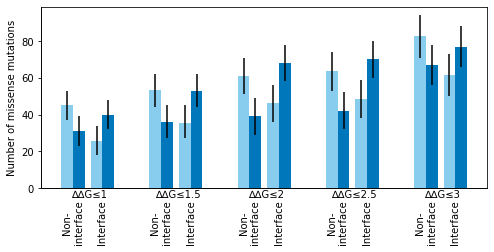

In [45]:
fig, ax = plt.subplots(figsize=(8, 4))
width = 0.4
x_pos = np.array([0, 1, 3, 4, 6, 7, 9, 10, 12, 13])

plt.bar(x_pos, expected_counts, yerr=[expected_counts-expected_ci_low, expected_ci_high-expected_counts],
        width=width, color=interface_expected_colour)
plt.bar(x_pos+width, observed_counts, yerr=[observed_counts-observed_ci_low, observed_ci_high-observed_counts],
        width=width, color=interface_observed_colour)
# plt.xticks(x_pos+width/2, ['False', 'True']*5)
plt.xticks(x_pos+width/2, ['Non-\ninterface', 'Interface']*5, rotation=90)
ax.tick_params(axis='x', direction='out', pad=12, length=0)
fig.subplots_adjust(bottom=0.25)
ax2 = plt.gca().twiny()
ax2.patch.set_visible(False)
hide_top_and_right_axes(ax2)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.set_xticks([0.75, 3.75, 6.75, 9.75, 12.75])
ax2.set_xticklabels(['∆∆G≤{}'.format(t) for t in thresholds])
ax2.set_xlim(ax.get_xlim())
ax2.tick_params(axis='x', length=0, pad=1.5)
# ax.set_xlabel('On interface')
ax.set_ylabel('Number of missense mutations')
# plt.subplots_adjust(left=0.3, bottom=0.3, right=1, top=1)
plt.savefig(os.path.join(plot_directory, 'bar_interface2_efg11_12_varying_threshold.pdf'), transparent=True)

# Calcium binding residues

## Defining calcium binding residues

Using the server MetalPDB https://academic.oup.com/nar/article/46/D1/D459/4564802  
http://metalweb.cerm.unifi.it

In [46]:
# Add the residues to the section definition dictionary.  
ca_binding_residues = [412, 413, 415, 431, 432, 435, 452, 453, 455, 469, 470]
section_definition_egf11_12['ca_binding_residues'] = ca_binding_residues

In [47]:
ca_lookup = SequenceDistanceLookup(
    boolean=True,   # Just a boolean binding/not binding. 
    target_key='ca_binding_residues',   # Use this entry in the section_definition dict to define the target residues
    position_type='residue',   # Use the residue number (as opposed to cdspos or chromosomal position)
    name='Calcium binding'  # Label to appear on plot axes
)

## Testing on full set of mutations

In [48]:
d_ca1 = d.change_lookup(ca_lookup)

In [49]:
s_ca1 = d_ca1.run_section(section_definition_egf11_12, spectra=main_fig_spectrum)

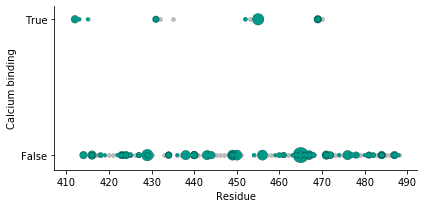

In [50]:
s_ca1.plot_scatter(figsize=(6, 3), show_legend=False, 
                  unobserved_mutation_colour=unobserved_colour, 
                   missense_mutation_colour=calcium_observed_colour,
                  base_marker_size=15, unmutated_marker_size=15)
plt.yticks([0, 1], ['False', 'True']);
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'scatter_ca1_efg11_12.pdf'), transparent=True)

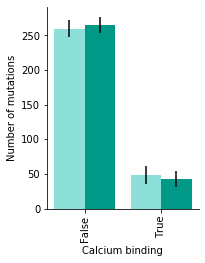

In [51]:
s_ca1.plot_binned_counts(figsize=(3, 4), show_legend=False, spectra=main_fig_spectrum,
                              colours=[calcium_observed_colour, calcium_expected_colour])
hide_top_and_right_axes()
plt.title('')
plt.xticks(plt.gca().get_xticks(), ['False', 'True'])
plt.xlabel('Calcium binding')
plt.subplots_adjust(left=0.3, bottom=0.3, right=1, top=1)
plt.savefig(os.path.join(plot_directory, 'bar_ca1_efg11_12.pdf'), transparent=True)

In [52]:
s_ca1_results = s_ca1.get_results_dictionary()

In [53]:
s_ca1_results['num_mutations']

308

In [54]:
s_ca1_results['CDF_perm__pvalue']  # P-value of permutation test

0.47503524964750354

In [55]:
# P-values using the alternative permutation tests. 
s_ca1_results['perm_mean__pvalue'], s_ca1_results['perm_median__pvalue']

(0.4764552354476455, 1)

## Testing after excluding destabilising and interface mutations

Testing the calcium binding mutations against all mutations in EGF11-12 does not find significant selection.  
Try excluding destabilising and interface mutations and test again.  

In [56]:
# First define a lookup that is 1 if the mutation is destabilising or on the interface and 0 otherwise.
destabilising_or_interface_lookup = ORLookup(
    lookups=[fold, interface_lookup],  # Use the FoldX and the interface lookups.  
    thresholds=[2, 0.5],  # Again pick a threshold of 2kcal/mol for the FoldX result, interface results are either 0 or 1 so set threshold at 0.5. 
    directions=[1, 1],  # Want to exclude mutations with scores greater than the thresholds, so directions are both 1.
)


# Define the combined lookup.
excllook2 = MutationExclusionLookup(
    lookup=ca_lookup,   # Use the calcium binding lookup for the test
    exclusion_lookup=destabilising_or_interface_lookup,   # Use the foldX lookup to exlcude mutations that have large ∆∆G values 
    exclusion_threshold=0.5,  #  Scores from the exclusion are either 0, or 1, so can put threshold anywhere in between.
    exclusion_direction=1,   # Exclude mutations with a score above the exclusion_threhold from the exclusion_lookup.
    name='Calcium binding'
)

In [57]:
d_ca2 = d.change_lookup(excllook2)

In [58]:
s_ca2 = d_ca2.run_section(section_definition_egf11_12, spectra=main_fig_spectrum)

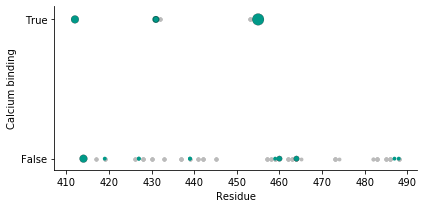

In [59]:
s_ca2.plot_scatter(figsize=(6, 3), show_legend=False, 
                  unobserved_mutation_colour=unobserved_colour, 
                   missense_mutation_colour=calcium_observed_colour,
                  base_marker_size=15, unmutated_marker_size=15)
plt.yticks([0, 1], ['False', 'True']);
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'scatter_ca2_efg11_12.pdf'), transparent=True)

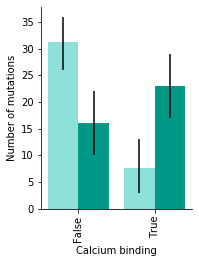

In [60]:
s_ca2.plot_binned_counts(figsize=(3, 4), show_legend=False, spectra=main_fig_spectrum,
                              colours=[calcium_observed_colour, calcium_expected_colour])
hide_top_and_right_axes()
plt.title('')
plt.xticks(plt.gca().get_xticks(), ['False', 'True'])
plt.xlabel('Calcium binding')
plt.subplots_adjust(left=0.3, bottom=0.3, right=1, top=1)
plt.savefig(os.path.join(plot_directory, 'bar_ca2_efg11_12.pdf'), transparent=True)

In [61]:
s_ca2_results = s_ca2.get_results_dictionary()

In [62]:
s_ca2_results['num_mutations']

39

In [63]:
s_ca2_results['CDF_perm__pvalue']  # P-value of permutation test

1.999980000199998e-05

In [64]:
# P-values using the alternative permutation tests. 
s_ca2_results['perm_mean__pvalue'], s_ca2_results['perm_median__pvalue']

(1.999980000199998e-05, 1.999980000199998e-05)

# Mutation categories

In [65]:
# For this plot, define a distance from the residues on the interface.
# As this is done on the 2VJ3 structure, which does not include the ligand, 
# this is the distance to the NOTCH1 residues on the interface, rather than directly distance from the ligand. 

# Add the target command for selecting the interface residues in the structure:
target_selection_string = 'protein and segid A and resid {} and name CA'.format(
    " ".join([str(int(p)) for p in section_definition_egf11_12['interface_residues']]))
section_definition_egf11_12['interface_residues_3D'] = target_selection_string


# Define the lookup that measure the distance in the structure from these selected residues
interface_lookup3D = StructureDistanceLookup(
    boolean=False,  # This time we use the distance
    target_key='interface_residues_3D', 
    name='Distance from interface residues (A)',
    
    # Uses the pdb file and SIFTS. Provide paths to directories including those files.
    pdb_directory=pdb_directory,
    sifts_directory=sifts_directory, 
    download_sifts=True   # Download the SIFTS file if not already in the directory

)
d_interface3D = d.change_lookup(interface_lookup3D)
s_interface3D = d_interface3D.run_section(section_definition_egf11_12, spectra=main_fig_spectrum)

/Users/mh28/miniconda3/envs/ds/lib/python3.7/site-packages/scipy/stats/stats.py:5048: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


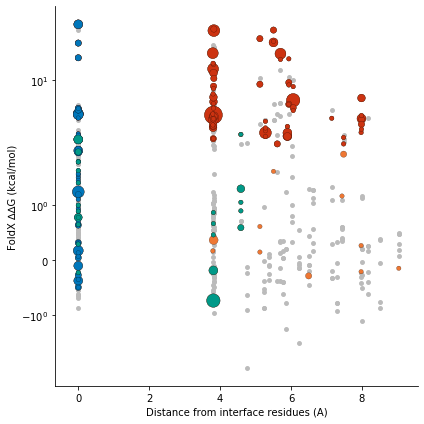

In [66]:
plot_scatter_two_scores(s_interface3D, s_fold, 
                        sections_for_colours=[s_fold, s_interface3D, s_ca1], 
                        score_regions_for_colours=[[2, 100], [-1, 0.1], [0.9,1.1]],
                        score_region_colours=[foldx_observed_colour, interface_observed_colour, calcium_observed_colour],
                        unobserved_mutation_colour=unobserved_colour, 
                        missense_mutation_colour=observed_colour,
                        plot_yscale='symlog', show_legend=False, figsize=(6, 6), unmutated_marker_size=15,
                        base_marker_size=20, annotate_mutations=False, annotate_xregion=[2, 10],
                            annotate_yregion=[-10000, 1.5], annotate_min_count=3, annotate_column='aachange',
                            annotation_offset=(-1.6, 0))
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'foldX_vs_interface_distance_efg11_12.pdf'), transparent=True)

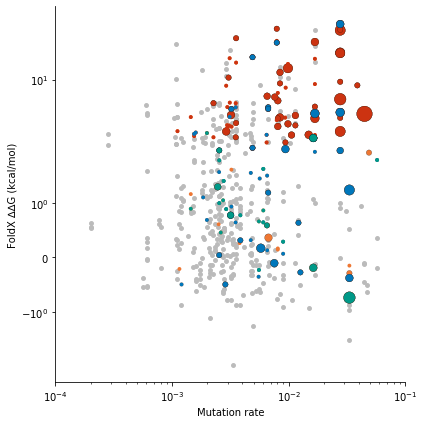

In [67]:
s_fold.plot_mutation_rate_scatter(figsize=(6, 6), metric_plot_scale='symlog', mut_rate_plot_scale='log',
                                  xlim=[0.0001, 0.1], spectra=main_fig_spectrum,
                                  unmutated_marker_size=15, base_marker_size=15, 
                                  unobserved_mutation_colour=unobserved_colour,
                                  missense_mutation_colour=observed_colour,
                                  show_legend=False, 
                                 sections_for_colours=[s_fold, s_interface1, s_ca1], 
                                 score_regions_for_colours=[[2, 100000], [0.5, 2], [0.5, 2]], 
                                 score_region_colours=[foldx_observed_colour, 
                                                       interface_observed_colour, 
                                                       calcium_observed_colour])
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'foldX_vs_mutation_rate_efg11_12.pdf'), transparent=True)

# Classifying all potential mutations

In [68]:
destabilising_or_interface_or_calcium_lookup = ORLookup(
    lookups=[fold, interface_lookup, ca_lookup],  # Use the FoldX, interface and calcium lookups.  
    thresholds=[2, 0.5, 0.5],  # Again pick a threshold of 2kcal/mol for the FoldX result, interface and calcium results are either 0 or 1 so set threshold at 0.5. 
    directions=[1, 1, 1],  # Want to exclude mutations with scores greater than the thresholds, so directions are all 1.
)
d_all = d.change_lookup(destabilising_or_interface_or_calcium_lookup)
s_all = d_all.run_section(section_definition_egf11_12, spectra=main_fig_spectrum)

In [69]:
# Proportion of mutations expected to occur in one of the three categories (not adjusting for spectrum)
len(s_all.null_mutations[s_all.null_mutations['score'] == 1])/len(s_all.null_mutations)

0.7029126213592233

In [70]:
# Proportion of mutations expected to occur in one of the three categories (adjusting for spectrum)
s_all.get_results_dictionary()['chi_square__binom_expected']

0.7070863957265402

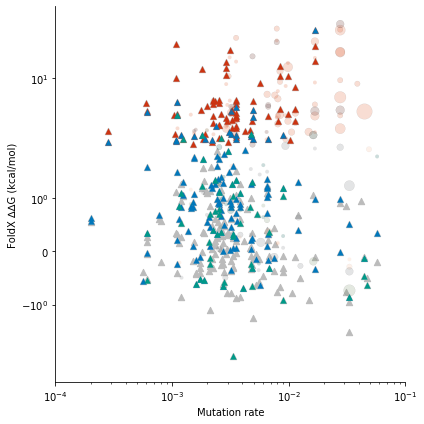

In [71]:
s_fold.plot_mutation_rate_scatter(figsize=(6, 6), metric_plot_scale='symlog', mut_rate_plot_scale='log',
                                  xlim=[0.0001, 0.1], spectra=main_fig_spectrum,
                                  unmutated_marker_size=40, base_marker_size=15, 
                                  unobserved_mutation_colour=unobserved_colour,
                                  missense_mutation_colour=observed_colour,
                                  show_legend=False, 
                                 sections_for_colours=[s_fold, s_interface1, s_ca1], 
                                 score_regions_for_colours=[[2, 100000], [0.5, 2], [0.5, 2]], 
                                 score_region_colours=[foldx_observed_colour, 
                                                       interface_observed_colour, 
                                                       calcium_observed_colour], 
                                  observed_alpha=0.1, 
                                 colour_unmutated_by_scores=True, unobserved_alpha=1, unobserved_marker='^')
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'foldX_vs_mutation_rate_unmutated_efg11_12.pdf'), transparent=True)

# Mutation rate vs observed mutations

In [72]:
obs_counts = s_fold.observed_mutations['ds_mut_id'].value_counts()

In [73]:
all_potential_mutations = s_fold.null_mutations.copy()

In [74]:
all_potential_mutations['obs_count'] = all_potential_mutations.apply(
    lambda x: obs_counts.get(x['ds_mut_id'], 0), axis=1)

In [75]:
from scipy.stats import linregress

r-squared= 0.15920463417941516 p-value= 4.211249267920599e-21


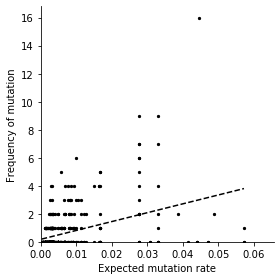

In [76]:
plt.figure(figsize=(4, 4))
x = all_potential_mutations[d.spectra[0].rate_column]
y = all_potential_mutations['obs_count']
plt.scatter(x, y, c='k', s=5)
slope, intercept, r_value, p_value, std_err = linregress(x,y)
print('r-squared=', r_value**2, 'p-value=', p_value)
plt.plot(np.unique(x), intercept + slope*np.unique(x), 'k--')
plt.ylabel('Frequency of mutation')
plt.xlabel('Expected mutation rate');
plt.xlim(left=0)
plt.ylim(bottom=0)
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'mutation_rate_vs_counts_efg11_12.pdf'), transparent=True)

# Alternative mutational spectra

In [77]:
spectra_colours = []
for spectra in supp_fig_spectra:
    if isinstance(spectra, EvenMutationalSpectrum):
        spectra_colours.append('k')
    elif isinstance(spectra, GlobalKmerSpectrum):
        spectra_colours.append('#bdbdbd')
    elif isinstance(spectra, TranscriptKmerSpectrum):
        spectra_colours.append('#636363')

## FoldX

In [78]:
s_fold_specta = d_fold.run_section(section_definition_egf11_12, spectra=supp_fig_spectra, 
                           statistics=cdf_perm)

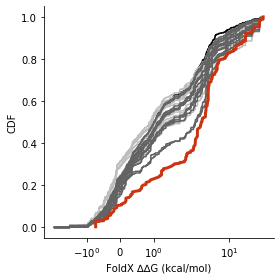

In [79]:
s_fold_specta.plot_cdfs(figsize=(4, 4), plot_scale='symlog', spectra=supp_fig_spectra, show_legend=False,
                       colours=[foldx_observed_colour] + spectra_colours)
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'foldX_multiple_spectra_cdf_plot.pdf'), transparent=True)

In [80]:
fold_spectra_res = s_fold_specta.get_results_dictionary()

In [81]:
fold_spectra_res = pd.DataFrame([
    {'spectrum': spectra.name, 'FoldX_pvalue': fold_spectra_res['CDF_perm_{}_pvalue'.format(spectra.name)]}
    for spectra in supp_fig_spectra
])

## Interface

In [82]:
# This excludes mutationsn with ∆∆G > 2kcal/mol
s_interface_spectra = d_interface2.run_section(section_definition_egf11_12, spectra=supp_fig_spectra,
                                              statistics=[cdf_perm, chi_sq])

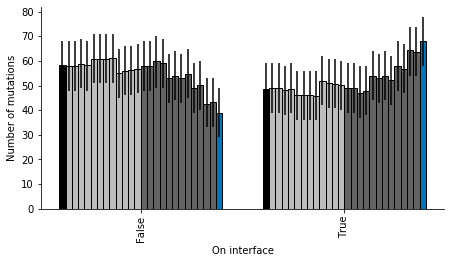

In [83]:
s_interface_spectra.plot_binned_counts_common_bins(
    figsize=(8, 4), show_legend=False, spectra=supp_fig_spectra, 
    colours=[interface_observed_colour] + spectra_colours,
    linewidth=1 
)
hide_top_and_right_axes()
plt.title('')
plt.xticks(plt.gca().get_xticks(), ['False', 'True'])
plt.xlabel('On interface')
plt.subplots_adjust(left=0.3, bottom=0.3, right=1, top=1)
plt.savefig(os.path.join(plot_directory, 'interface_multiple_spectra.pdf'), transparent=True)

In [84]:
interface_spectra_res = s_interface_spectra.get_results_dictionary()
interface_spectra_res = pd.DataFrame([
    {'spectrum': spectra.name, 'interface_pvalue': interface_spectra_res['CDF_perm_{}_pvalue'.format(spectra.name)]}
    for spectra in supp_fig_spectra
])

## Calcium binding

In [85]:
# This excludes mutationsn with ∆∆G > 2kcal/mol and on the ligand-binding interface
s_calcium_spectra = d_ca2.run_section(section_definition_egf11_12, spectra=supp_fig_spectra,
                                    statistics=[cdf_perm, chi_sq])

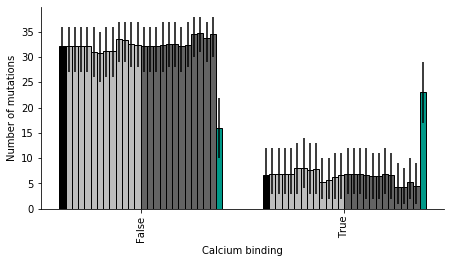

In [86]:
s_calcium_spectra.plot_binned_counts_common_bins(
    figsize=(8, 4), show_legend=False, spectra=supp_fig_spectra, 
    colours=[calcium_observed_colour] + spectra_colours,
    linewidth=1
)
hide_top_and_right_axes()
plt.title('')
plt.xticks(plt.gca().get_xticks(), ['False', 'True'])
plt.xlabel('Calcium binding')
plt.subplots_adjust(left=0.3, bottom=0.3, right=1, top=1)
plt.savefig(os.path.join(plot_directory, 'ca_binding_multiple_spectra.pdf'), transparent=True)

In [87]:
calcium_spectra_res = s_calcium_spectra.get_results_dictionary()
calcium_spectra_res = pd.DataFrame([
    {'spectrum': spectra.name, 'calcium_pvalue': calcium_spectra_res['CDF_perm_{}_pvalue'.format(spectra.name)]}
    for spectra in supp_fig_spectra
])

## Alternative spectra pvalues

In [88]:
all_p = pd.merge(fold_spectra_res, interface_spectra_res)
all_p = pd.merge(all_p, calcium_spectra_res)

In [89]:
all_p

,spectrum,FoldX_pvalue,interface_pvalue,calcium_pvalue
0,EvenMutationalSpectrum,0.00002,0.000300,0.00002
1,global_6,0.00002,0.000320,0.00002
2,global_6_dedup,0.00002,0.000300,0.00002
3,global_12,0.00002,0.000120,0.00002
4,global_12_dedup,0.00002,0.000220,0.00002
5,global_96,0.00002,0.000040,0.00002
6,global_96_dedup,0.00002,0.000040,0.00002
7,global_192,0.00002,0.000040,0.00002
8,global_192_dedup,0.00002,0.000040,0.00002
9,global_1536,0.00002,0.002260,0.00002
